#**Import modules**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras

# Import necessary libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set random seeds for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Mounted at /content/drive


#**Load the data**

In [ ]:
# Define access path
base_path = "/content/drive/MyDrive/dataset"
# Folder paths
pssm_folder = os.path.join(base_path, "pssm")
fasta_folder = os.path.join(base_path, "fasta")
dssp_folder = os.path.join(base_path, "dssp")
# Get the protein IDs
protein_IDs = ['.'.join(f.split('.')[:-1]) for f in os.listdir(dssp_folder)]
print('All paths obtained...')

# Load the data
def load_pssm(filepath):
    """Load PSSM as a NumPy array"""
    return pd.read_csv(filepath).to_numpy()

def load_dssp(filepath):
    """Load DSSP as a string"""
    labels= []
    with open(filepath, "r") as f:
        return "".join(line.strip() for line in f if not line.startswith(">"))

def load_fasta(filepath):
    """Load FASTA sequence as a string"""
    labels_indexs= []
    with open(filepath, "r") as f:
        return "".join(line.strip() for line in f if not line.startswith(">"))

# One-hot-encode
voc_aa = 'ARNDCQEGHILKMFPSTWYV'
def one_hot_encode_fasta(seq):
    """Convert FASTA sequence to one-hot encoded NumPy array"""
   # Create mapping of amino acids to indices
    aa_to_idx = {aa: i for i, aa in enumerate(voc_aa)}

    # Initialize one-hot matrix
    one_hot = np.zeros((len(seq), 20))

    # Fill one-hot matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:  # Check if amino acid is in vocabulary
            one_hot[i, aa_to_idx[aa]] = 1
    return one_hot

voc_ss= 'HECX'
def one_hot_encode_dssp(seq):
    """Convert DSSP sequence to one-hot encoded NumPy array"""
   # Create mapping of amino acids to indices
    dssp_to_idx = {aa: i for i, aa in enumerate(voc_ss)}

    # Initialize one-hot matrix
    one_hot = np.zeros((len(seq), 4))

    # Fill one-hot matrix
    for i, ss in enumerate(seq):
        if ss in dssp_to_idx:  # Check if amino acid is in vocabulary
            one_hot[i, dssp_to_idx[ss]] = 1
    return one_hot

# Spliting the data
# Split data into train, validation, and test sets
def split_data(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Split data into train, validation, and test sets"""
    # Ensure random seed is set to 0 for reproducibility
    np.random.seed(0)

    n = len(X)
    indices = np.random.permutation(n)

    # Calculate split indices
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)

    # Split indices
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create splits
    X_train = [X[i] for i in train_indices]
    y_train = [y[i] for i in train_indices]

    X_val = [X[i] for i in val_indices]
    y_val = [y[i] for i in val_indices]

    X_test = [X[i] for i in test_indices]
    y_test = [y[i] for i in test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

import numpy as np
import tensorflow as tf

# We write a function for padding the dssp data with coils = [1, 0, 0]
def pad_dssp(dssp_data, max_len):
    """Pad DSSP data with a dummy 4th class to the same length"""
    padded_data = []
    pad_value = np.array([0, 0, 0, 1])
    for dssp in dssp_data:
      num_padding = max_len - len(dssp)
      if num_padding > 0:
          padding = np.tile(pad_value, (num_padding, 1))
          padded_seq = np.vstack([dssp, padding])
      else:
        padded_seq = dssp[:max_len]  # Truncate if longer than max_len

      padded_data.append(padded_seq)

    return padded_data


# Load all data
print('Loading data...')
fasta_data = []
dssp_data = []
pssm_data = []

for protein in protein_IDs:
  # Get the paths
  fasta_path = os.path.join(fasta_folder, protein + '.fasta')
  dssp_path = os.path.join(dssp_folder, protein + '.dssp')
  pssm_path = os.path.join(pssm_folder, protein + '.csv')

  fasta_file = load_fasta(fasta_path)
  dssp_file = load_dssp(dssp_path)
  pssm_file = load_pssm(pssm_path)

    # Check that files have the same len
  if len(fasta_file) != len(dssp_file) or len(fasta_file) != len(pssm_file):
    print(f"Skipping {protein} due to different lengths")
    print(f"fasta: {len(fasta_file)}, dssp: {len(dssp_file)}, pssm: {len(pssm_file)}")
    continue
  else:
      # One-hot encode sequences
    fasta_encoded = one_hot_encode_fasta(fasta_file)
    dssp_encoded = one_hot_encode_dssp(dssp_file)

      # Store data
    fasta_data.append(fasta_encoded)
    dssp_data.append(dssp_encoded)
    pssm_data.append(pssm_file)

max_len = max(max(len(seq) for seq in fasta_data),
              max(len(seq) for seq in dssp_data),
              max(len(seq) for seq in pssm_data))
# Pad the data
dssp_data = pad_dssp(dssp_data, max_len)
pssm_data = tf.keras.preprocessing.sequence.pad_sequences(pssm_data, maxlen=max_len, padding="post")
fasta_data = tf.keras.preprocessing.sequence.pad_sequences(fasta_data, maxlen=max_len, padding="post")
# Split into 80% training, 10% validation, 10% test
print('Splitting data...')
fasta_train, dssp_train, fasta_val, dssp_val, fasta_test, dssp_test = split_data(fasta_data, dssp_data)
pssm_train, dssp_train_pssm, pssm_val, dssp_val_pssm, pssm_test, dssp_test_pssm = split_data(pssm_data, dssp_data)

print(f"Training samples: {len(fasta_train)}")
print(f"Validation samples: {len(fasta_val)}")
print(f"Test samples: {len(fasta_test)}")



# Transform into np.arrays
pssm_train = np.array(pssm_train)
dssp_train_pssm = np.array(dssp_train_pssm)
pssm_val = np.array(pssm_val)
dssp_val_pssm = np.array(dssp_val_pssm)
pssm_test = np.array(pssm_test)
dssp_test_pssm = np.array(dssp_test_pssm)
fasta_train = np.array(fasta_train)
dssp_train = np.array(dssp_train)
fasta_val = np.array(fasta_val)
dssp_val = np.array(dssp_val)
fasta_test = np.array(fasta_test)
dssp_test = np.array(dssp_test)
print('Data loaded and proccessed!')



All paths obtained...
Loading data...
Skipping d2ciwa1 due to different lengths
fasta: 299, dssp: 299, pssm: 298
Skipping d3u81a_ due to different lengths
fasta: 219, dssp: 219, pssm: 218
Splitting data...
Training samples: 958
Validation samples: 119
Test samples: 121
Data loaded and proccessed!


#**Model training**

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def masked_accuracy(y_true, y_pred):
    """
    Calculate the accuracy ignoring the padding class (X).
    """
    # Get the class index
    true_classes = tf.argmax(y_true, axis=-1)
    pred_classes = tf.argmax(y_pred, axis=-1)

    # Create a mask to ignore the outputs with padding class (X)
    mask = tf.not_equal(true_classes, 3)  # True if HEC, False if X

    # Filter values
    correct_predictions = tf.equal(true_classes, pred_classes)
    correct_predictions = tf.boolean_mask(correct_predictions, mask)

    # Accuracy just accounting for HEC
    return tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))


# Model 1: 2 Bidirectional layers

In [ ]:
import keras
from keras.layers import Input, Reshape, Dense, Activation, BatchNormalization, Flatten, Conv1D, concatenate, Bidirectional, LSTM, Dropout
from keras.models import Model

input_shape = pssm_train[0].shape

model1 = keras.Sequential()
model1.add(Input(shape = input_shape))
model1.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
model1.add(layers.Dropout(0.3))
model1.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
model1.add(layers.Dropout(0.3))
model1.add(Dense(128, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(Dense(4, activation='softmax'))
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 759, 256)            │         152,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 759, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 759, 128)            │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 759, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,956 (1.27 MB)

 Trainable params: 333,956 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history1 = model1.fit(pssm_train, dssp_train_pssm, batch_size=batch_size,
                         epochs=epochs, validation_data=(pssm_val, dssp_val_pssm),
                         callbacks=[early_stopping])

Epoch 1/15
 3/30 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - accuracy: 0.4281 - loss: 1.3612 - masked_accuracy: 0.3742

KeyboardInterrupt: 

# Model 2: Conv1D layer + Bidirectional layer

In [ ]:
model2 = keras.Sequential()
model2.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (759,20)))
model2.add(BatchNormalization())
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation= 'relu'))
model2.add(Dense(4, activation='softmax'))
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 759, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 759, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 759, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 759, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,236 (340.77 KB)

 Trainable params: 87,108 (340.27 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history2 = model2.fit(pssm_train, dssp_train_pssm, batch_size=batch_size,
                         epochs=epochs, validation_data=(pssm_val, dssp_val_pssm),
                         callbacks=[early_stopping])

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 970ms/step - accuracy: 0.7468 - loss: 0.6936 - masked_accuracy: 0.4148 - val_accuracy: 0.9179 - val_loss: 0.1902 - val_masked_accuracy: 0.6145
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 987ms/step - accuracy: 0.9158 - loss: 0.1928 - masked_accuracy: 0.6248 - val_accuracy: 0.9313 - val_loss: 0.1618 - val_masked_accuracy: 0.6774
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 986ms/step - accuracy: 0.9280 - loss: 0.1676 - masked_accuracy: 0.6785 - val_accuracy: 0.9361 - val_loss: 0.1515 - val_masked_accuracy: 0.6991
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 960ms/step - accuracy: 0.9333 - loss: 0.1578 - masked_accuracy: 0.7019 - val_accuracy: 0.9391 - val_loss: 0.1454 - val_masked_accuracy: 0.7120
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 971ms/step - accuracy: 0.9369 - loss: 0.1506 - masked_accuracy: 0.7180 - val_accuracy: 0.9420 - val_loss: 0.1390 - val_masked_accuracy: 0.7252
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 919ms/step - accuracy: 0.9398 - l

#**Model evaluation**

# Functions

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, suptitle=''):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_masked_acc = history.history.get('masked_accuracy', [])
    val_masked_acc = history.history.get('val_masked_accuracy', [])

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Figure with 2 graphs
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(suptitle)

    # Accuracy for training and validation
    axs[0].plot(epochs, train_acc, 'b', label='Training acc')
    axs[0].plot(epochs, val_acc, 'r', label='Validation acc')

    if train_masked_acc and val_masked_acc:
        axs[0].plot(epochs, train_masked_acc, 'g', label='Training masked acc')
        axs[0].plot(epochs, val_masked_acc, 'y', label='Validation masked acc')

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training & Validation Accuracy')
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid()

    # Loss curve
    axs[1].plot(epochs, train_loss, 'b', label='Training loss')
    axs[1].plot(epochs, val_loss, 'r', label='Validation loss')

    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training & Validation Loss')
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, matthews_corrcoef

def plot_confusion_matrix_pad(model, pssm_test, dssp_test_pssm, suptitle='', color= 'Greens'):
  # Model predictions (probabilities)
  y_pred_prob = model.predict(pssm_test)

  # Convert to class indices
  y_pred = np.argmax(y_pred_prob, axis=-1)  # Predictions
  y_true = np.argmax(dssp_test_pssm, axis=-1)  # True labels

  y_pred_flat = y_pred.flatten()
  y_true_flat = y_true.flatten()

  # Define class names
  class_names = ['Helix', 'Sheet','Coil', 'Padded']

  # Compute confusion matrix
  cm = confusion_matrix(y_true_flat, y_pred_flat)

  # Plot the confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap= color, xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.suptitle(suptitle)
  plt.show()

def plot_confusion_matrix(model, pssm_test, dssp_test_pssm, suptitle='', color= 'Greens'):
  # Model predictions (probabilities)
  y_pred_prob = model.predict(pssm_test)

  # Convert to class indices
  y_pred = np.argmax(y_pred_prob, axis=-1)  # Predictions
  y_true = np.argmax(dssp_test_pssm, axis=-1)  # True labels

  # Flatten sequences
  y_pred_flat = y_pred.flatten()
  y_true_flat = y_true.flatten()

  # Mask: Ignore any case where either true OR predicted label is 'Padded' (index 3)
  mask = (y_true_flat != 3) & (y_pred_flat != 3)
  y_pred_filtered = y_pred_flat[mask]
  y_true_filtered = y_true_flat[mask]

 # Metrics
  accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
  precision = precision_score(y_true_filtered, y_pred_filtered, average='macro')
  mcc = matthews_corrcoef(y_true_filtered, y_pred_filtered)

  # Define class names excluding "Padded"
  class_names = ["Helix", "Sheet", "Coil"]

  # Compute confusion matrix
  cm = confusion_matrix(y_true_filtered, y_pred_filtered)

  # Plot the confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap= color, xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix (Without Padding)")
  plt.suptitle(suptitle)
  plt.show()

  return [accuracy, precision, mcc]


In [ ]:
def get_metrics(model, h, x_test, y_test):
  test_acc = model.evaluate(x_test, y_test)[0]
  acc = h.history['accuracy'][-1]
  mask_acc = h.history['masked_accuracy'][-1]
  vacc = h.history['val_accuracy'][-1]
  vmask_acc = h.history['val_masked_accuracy'][-1]
  loss = h.history['loss'][-1]
  val_loss = h.history['val_loss'][-1]
  return [acc, mask_acc, vacc, vmask_acc, loss, val_loss]

In [ ]:
def plot_model_comparison(data, labels, title, cm= False):
    """
   Generates a bar chart to compare multiple models.

    Parameters:
    - data: list of lists, where each sublist represents the values of a model according to the metrics.
    - labels: list of model names.
    - title: title of the graphic
    - cm: True if we want to plot confusion matrix metrics

    """
    if cm:
        metrics = ['Accuracy', 'Precision', 'MCC']
    else:
        metrics = ['Accuracy', 'Masked Accuracy', 'Val Accuracy', 'Val Masked Accuracy', 'Loss', 'Val Loss']

    num_models = len(data)
    num_metrics = len(metrics)

    x = np.arange(num_metrics)  # X axis
    width = 0.8 / num_models  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each model with an offset on the X-axis.
    for i, (model_data, label) in enumerate(zip(data, labels)):
        ax.bar(x + i * width - (width * (num_models - 1) / 2), model_data, width, label=label)

    # Plot conf
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylabel('Value')
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.legend()

    plt.show()

#Model 1: 2 Bidirectional layer

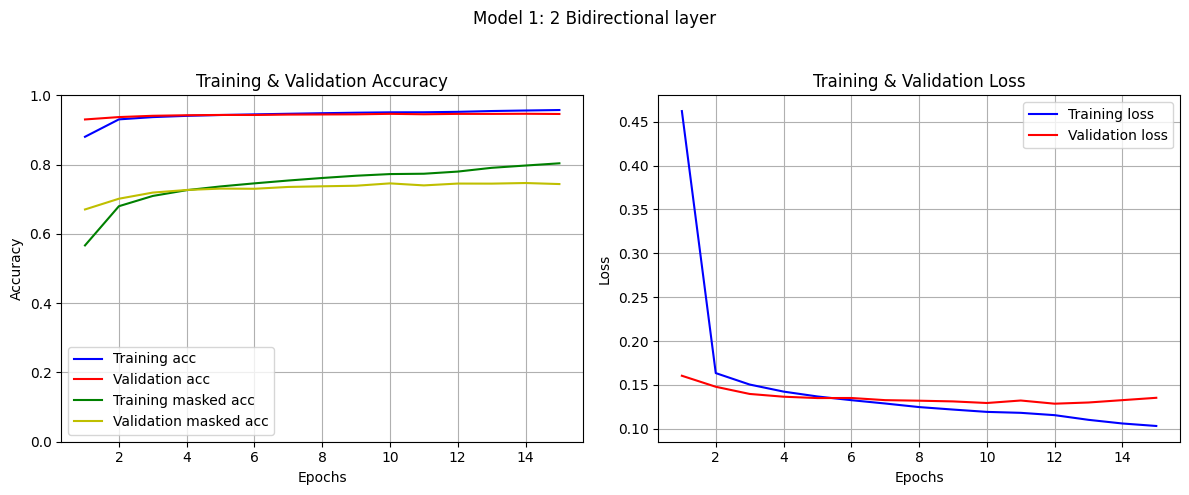

In [ ]:
plot_history(history1, suptitle='Model 1: 2 Bidirectional layer')

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


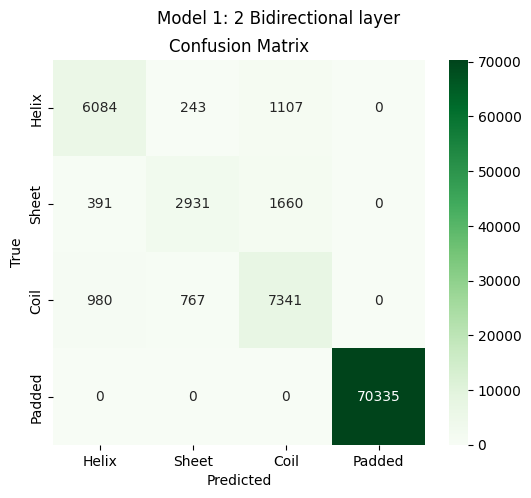

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


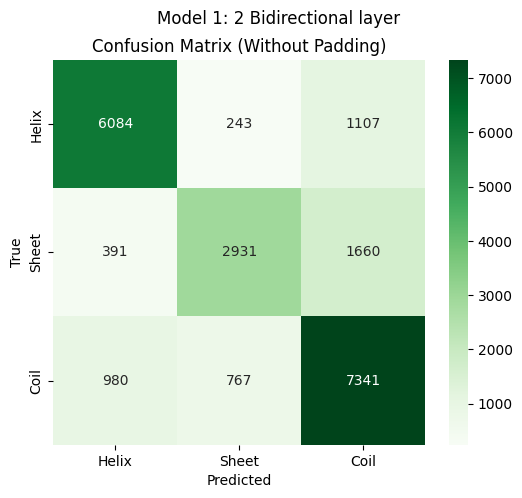

In [ ]:
plot_confusion_matrix_pad(model1, pssm_test, dssp_test_pssm, suptitle='Model 1: 2 Bidirectional layer')
cm_metrics_m1= plot_confusion_matrix(model1, pssm_test, dssp_test_pssm, suptitle='Model 1: 2 Bidirectional layer')

In [ ]:
metrics_model1 = get_metrics(model1, history1, pssm_test, dssp_test_pssm)
print(metrics_model1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 896ms/step - accuracy: 0.9485 - loss: 0.1246 - masked_accuracy: 0.7675
[0.9575764536857605, 0.8037503957748413, 0.946158766746521, 0.7438597083091736, 0.1031370535492897, 0.135257750749588]


#Model 2: Conv1D + Bidirectional layer

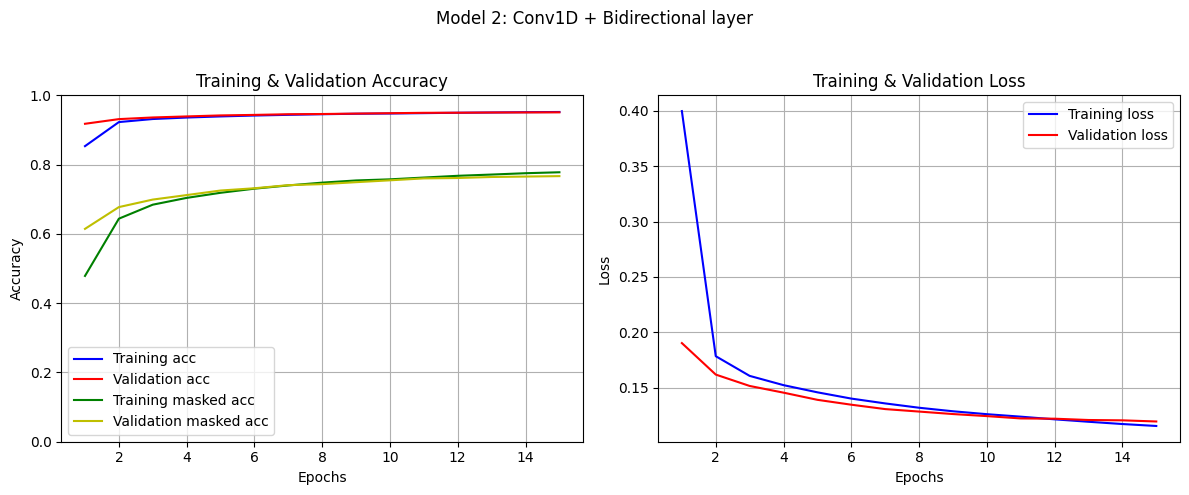

In [ ]:
plot_history(history2, suptitle='Model 2: Conv1D + Bidirectional layer')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


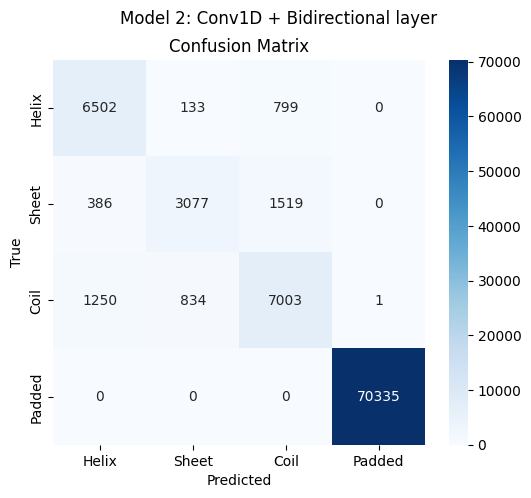

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


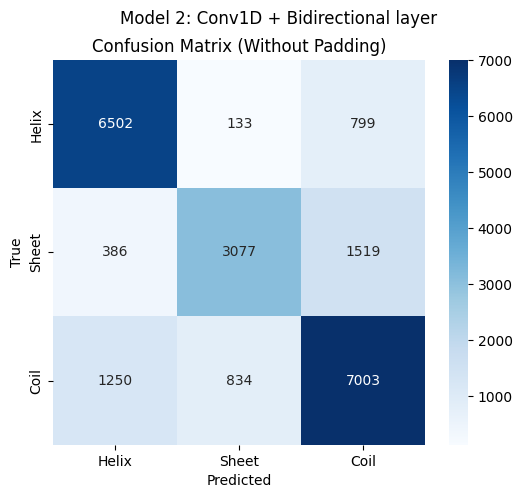

In [ ]:
plot_confusion_matrix_pad(model2, pssm_test, dssp_test_pssm, suptitle='Model 2: Conv1D + Bidirectional layer', color= 'Blues')
cm_metrics_m2= plot_confusion_matrix(model2, pssm_test, dssp_test_pssm, suptitle='Model 2: Conv1D + Bidirectional layer', color='Blues')

In [ ]:
metrics_model2 = get_metrics(model2, history2, pssm_test, dssp_test_pssm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.9501 - loss: 0.1187 - masked_accuracy: 0.7734


#**Model with FASTA data**

# Model 1

In [ ]:
import keras
from keras.layers import Input, Reshape, Dense, Activation, BatchNormalization, Flatten, Conv1D, concatenate, Bidirectional, LSTM, Dropout
from keras.models import Model

input_shape = fasta_train[0].shape

model1_fasta = keras.Sequential()
model1_fasta.add(Input(shape = input_shape))
model1_fasta.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
model1_fasta.add(layers.Dropout(0.3))
model1_fasta.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
model1_fasta.add(layers.Dropout(0.3))
model1_fasta.add(Dense(128, activation='relu'))
model1_fasta.add(layers.Dropout(0.3))
model1_fasta.add(Dense(4, activation='softmax'))
model1_fasta.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 759, 256)            │         152,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 759, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 759, 128)            │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 759, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,956 (1.27 MB)

 Trainable params: 333,956 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
model1_fasta.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history1_fasta = model1_fasta.fit(fasta_train, dssp_train, batch_size=batch_size,
                         epochs=epochs, validation_data=(fasta_val, dssp_val),
                         callbacks=[early_stopping])

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.7599 - loss: 0.8818 - masked_accuracy: 0.3689 - val_accuracy: 0.8791 - val_loss: 0.2326 - val_masked_accuracy: 0.4282
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8709 - loss: 0.2488 - masked_accuracy: 0.4239 - val_accuracy: 0.8995 - val_loss: 0.2152 - val_masked_accuracy: 0.5230
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8883 - loss: 0.2293 - masked_accuracy: 0.5009 - val_accuracy: 0.9051 - val_loss: 0.2012 - val_masked_accuracy: 0.5494
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8990 - loss: 0.2142 - masked_accuracy: 0.5485 - val_accuracy: 0.9118 - val_loss: 0.1898 - val_masked_accuracy: 0.5815
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9054 - loss: 0.2050 - masked_accuracy: 0.5776 - val_accuracy: 0.9172 - val_loss: 0.1835 - val_masked_accuracy: 0.6066
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.9106 - loss: 0.1979 

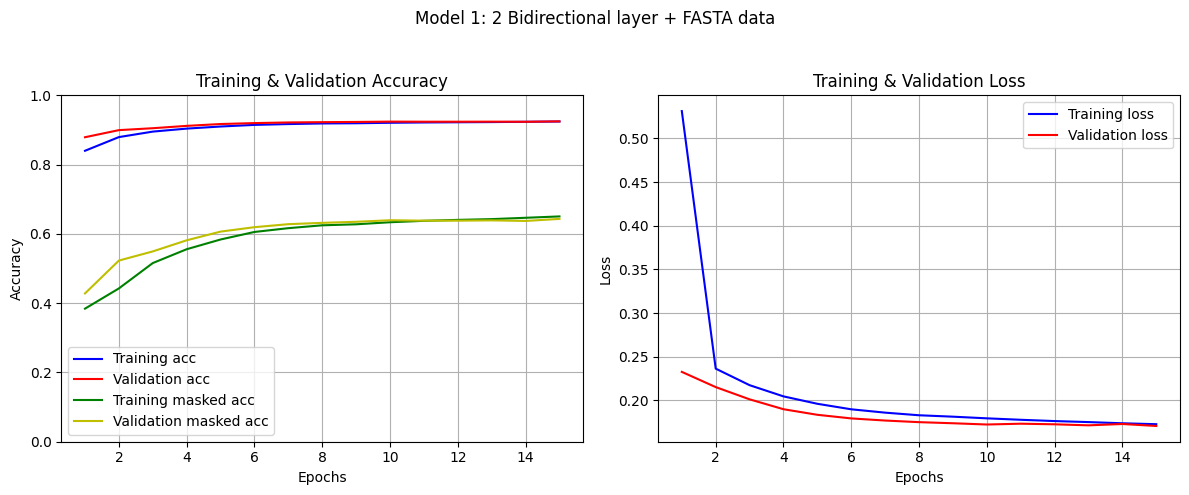

In [ ]:
plot_history(history1_fasta, suptitle='Model 1: 2 Bidirectional layer + FASTA data')

In [ ]:
metrics_fasta_1 = get_metrics(model1_fasta, history1_fasta, fasta_test, dssp_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9238 - loss: 0.1735 - masked_accuracy: 0.6554


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


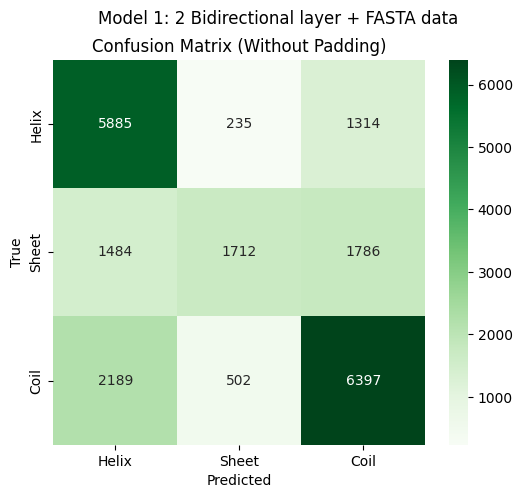

In [ ]:
cm_metrics_fasta1 = plot_confusion_matrix(model1_fasta, fasta_test, dssp_test, suptitle='Model 1: 2 Bidirectional layer + FASTA data')

#Model 2

In [ ]:
input_shape = fasta_train[0].shape

model2_fasta = keras.Sequential()
model2_fasta.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (759,20)))
model2_fasta.add(BatchNormalization())
model2_fasta.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
model2_fasta.add(layers.Dropout(0.3))
model2_fasta.add(Dense(128, activation='relu'))
model2_fasta.add(layers.Dropout(0.3))
model2_fasta.add(Dense(4, activation='softmax'))
model2_fasta.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 759, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 759, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 759, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 759, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,236 (340.77 KB)

 Trainable params: 87,108 (340.27 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
model2_fasta.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history2_fasta = model2_fasta.fit(fasta_train, dssp_train, batch_size=batch_size,
                         epochs=epochs, validation_data=(fasta_val, dssp_val),
                         callbacks=[early_stopping])

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7593 - loss: 0.6735 - masked_accuracy: 0.4047 - val_accuracy: 0.8648 - val_loss: 0.2799 - val_masked_accuracy: 0.3587
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8954 - loss: 0.2218 - masked_accuracy: 0.5332 - val_accuracy: 0.8840 - val_loss: 0.2454 - val_masked_accuracy: 0.4492
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9072 - loss: 0.2053 - masked_accuracy: 0.5855 - val_accuracy: 0.8914 - val_loss: 0.2302 - val_masked_accuracy: 0.4841
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9111 - loss: 0.1985 - masked_accuracy: 0.6027 - val_accuracy: 0.8970 - val_loss: 0.2221 - val_masked_accuracy: 0.5107
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9138 - loss: 0.1931 - masked_accuracy: 0.6149 - val_accuracy: 0.9019 - val_loss: 0.2140 - val_masked_accuracy: 0.5342
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9158 - loss: 0.1895 - mask

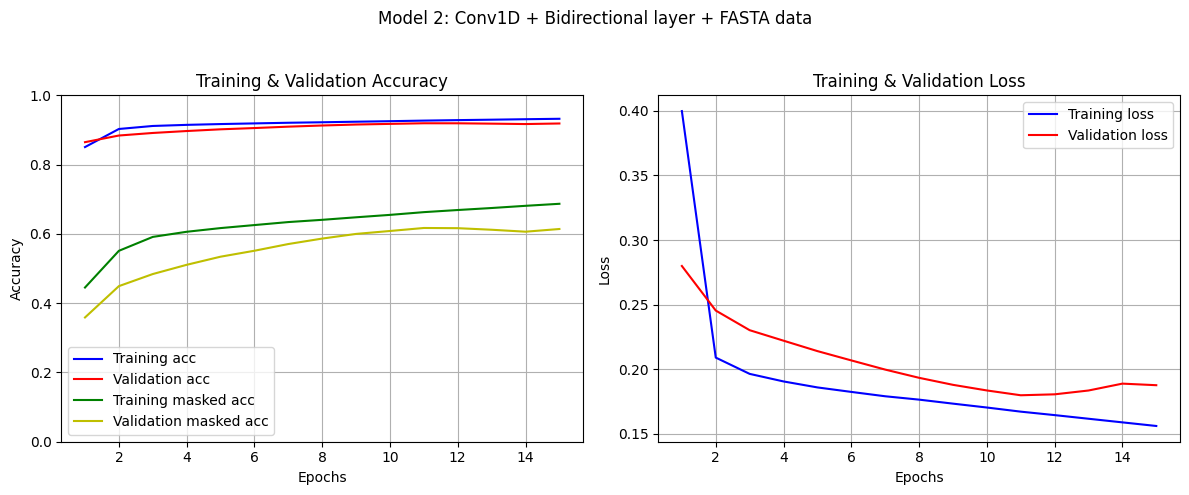

In [ ]:
plot_history(history2_fasta, suptitle='Model 2: Conv1D + Bidirectional layer + FASTA data')

In [ ]:
metrics_fasta_2 = get_metrics(model2_fasta, history2_fasta, fasta_test, dssp_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9188 - loss: 0.1846 - masked_accuracy: 0.6329


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step


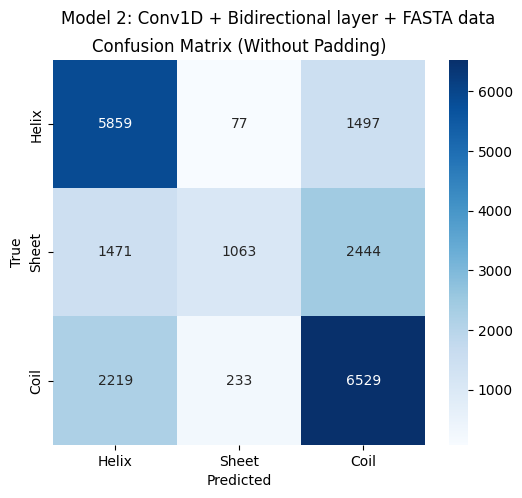

In [ ]:
cm_metrics_fasta2= plot_confusion_matrix(model2_fasta, fasta_test, dssp_test, suptitle='Model 2: Conv1D + Bidirectional layer + FASTA data', color='Blues')

#**Model comparisons**

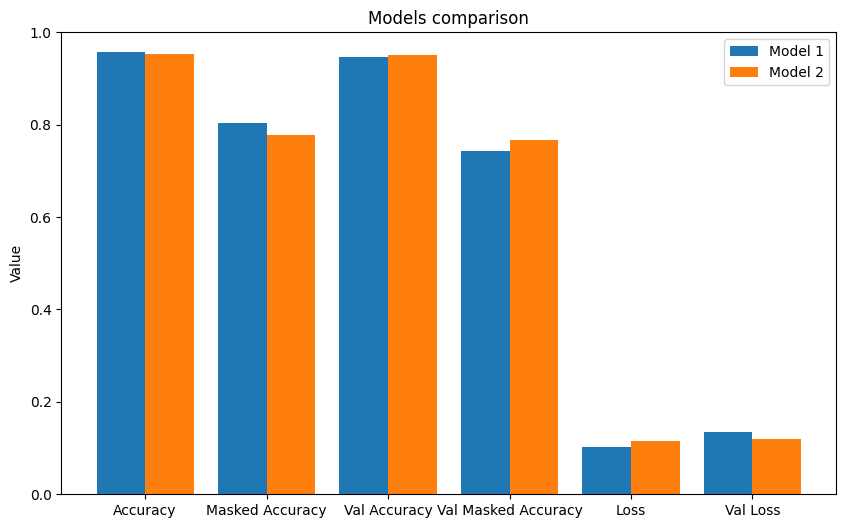

In [ ]:
metrics = [metrics_model1, metrics_model2]
labels = ['Model 1', 'Model 2']
plot_model_comparison(metrics, labels, title= 'Models comparison')

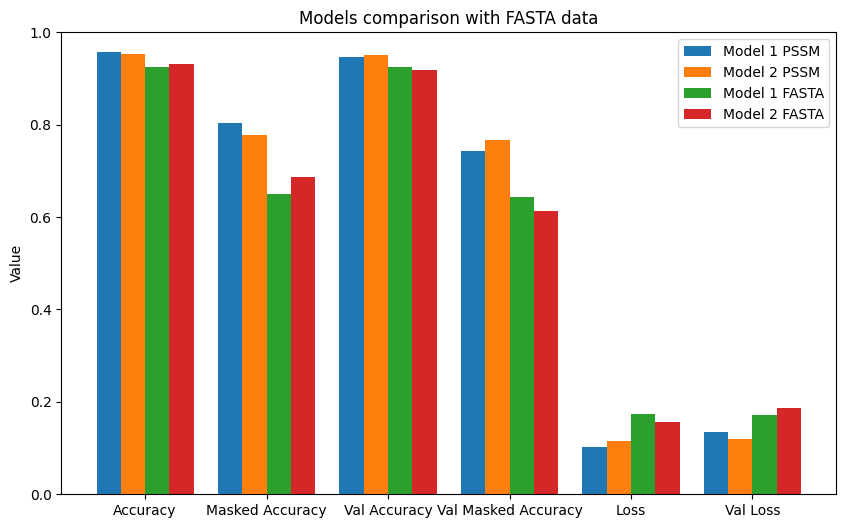

In [ ]:
metrics_fasta = [metrics_model1, metrics_model2, metrics_fasta_1, metrics_fasta_2]
labels = ['Model 1 PSSM', 'Model 2 PSSM', 'Model 1 FASTA', 'Model 2 FASTA']
plot_model_comparison(metrics_fasta, labels, title= 'Models comparison with FASTA data')

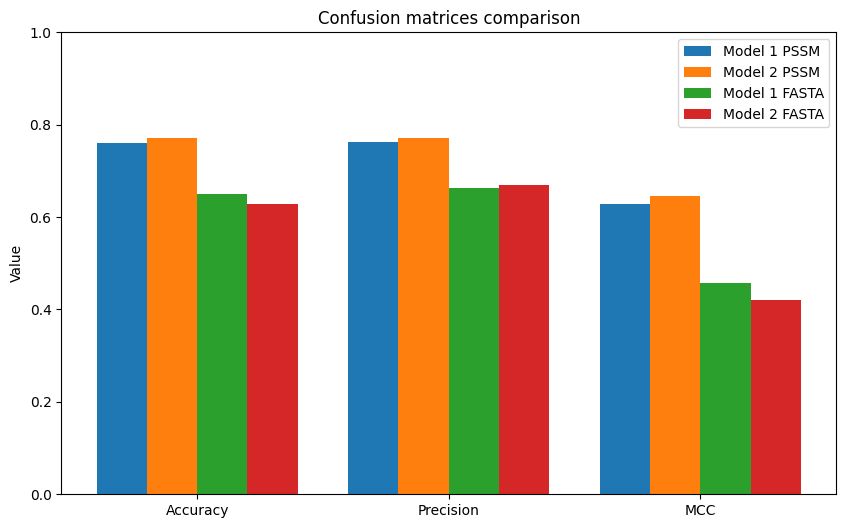

In [ ]:
cm_metrics = [cm_metrics_m1, cm_metrics_m2, cm_metrics_fasta1, cm_metrics_fasta2]
labels = ['Model 1 PSSM', 'Model 2 PSSM', 'Model 1 FASTA', 'Model 2 FASTA']
plot_model_comparison(cm_metrics, labels, title= 'Confusion matrices comparison', cm= True)

#**Ablation studies**

Given the similarity in performance between models, I chose the second one to perform the ablations as it computationally less expensive.

#Ablation 1: Convolutional layer

In [ ]:

m1 = keras.Sequential()
# m1.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (759,20)))
# m1.add(BatchNormalization())
m1.add(Bidirectional(LSTM(64, return_sequences=True)))
m1.add(Dropout(0.3))
m1.add(Dense(128, activation= 'relu'))
m1.add(Dense(4, activation='softmax'))
m1.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
m1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_1 = m1.fit(pssm_train, dssp_train_pssm, batch_size=batch_size,
                         epochs=epochs, validation_data=(pssm_val, dssp_val_pssm),
                         callbacks=[early_stopping])

In [ ]:
abl_conv = get_metrics(m1, history_1, pssm_test, dssp_test_pssm)

In [ ]:
cm_metrics_abl_con = plot_confusion_matrix(m1, pssm_test, dssp_test_pssm, suptitle='Ablation: Convolutional layer',color= 'Reds')

#Ablation 2: Bidirectional layer




In [ ]:
# Ablation of the Biridectional layer
m2 = keras.Sequential()
m2.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (759,20)))
m2.add(BatchNormalization())
# m.add(Bidirectional(LSTM(64, return_sequences=True)))
m2.add(Dropout(0.3))
m2.add(Dense(128, activation= 'relu'))
m2.add(Dense(4, activation='softmax'))
m2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 759, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 759, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 759, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 759, 128)            │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,996 (50.77 KB)

 Trainable params: 12,868 (50.27 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
m2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_2 = m2.fit(pssm_train, dssp_train_pssm, batch_size=batch_size,
                         epochs=epochs, validation_data=(pssm_val, dssp_val_pssm),
                         callbacks=[early_stopping])

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7528 - loss: 1.0809 - masked_accuracy: 0.3279 - val_accuracy: 0.9036 - val_loss: 0.4886 - val_masked_accuracy: 0.5487
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8953 - loss: 0.2513 - masked_accuracy: 0.5376 - val_accuracy: 0.9160 - val_loss: 0.2445 - val_masked_accuracy: 0.6076
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9025 - loss: 0.2225 - masked_accuracy: 0.5694 - val_accuracy: 0.9181 - val_loss: 0.2106 - val_masked_accuracy: 0.6173
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9050 - loss: 0.2157 - masked_accuracy: 0.5800 - val_accuracy: 0.9191 - val_loss: 0.1982 - val_masked_accuracy: 0.6221
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9077 - loss: 0.2101 - masked_accuracy: 0.5919 - val_accuracy: 0.9194 - val_loss: 0.1925 - val_masked_accuracy: 0.6235
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9089 - loss: 0.206

In [ ]:
abl_bidir = get_metrics(m2, history_2, pssm_test, dssp_test_pssm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9191 - loss: 0.1852 - masked_accuracy: 0.6332


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


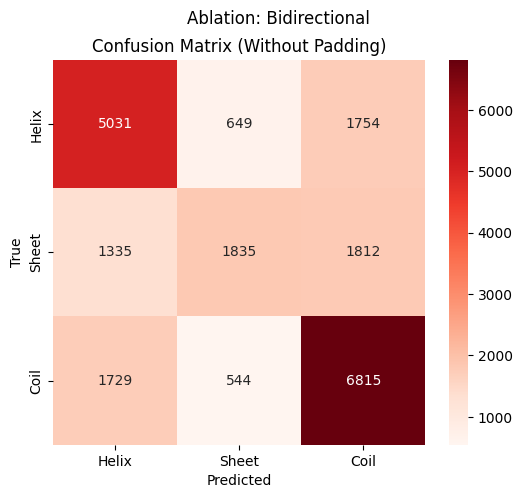

In [ ]:
cm_metrics_abl_bidir= plot_confusion_matrix(m2, pssm_test, dssp_test_pssm, suptitle='Ablation: Bidirectional', color= 'Reds')

#Ablation 3: Dense Layer

In [ ]:
# Ablation of the Biridectional layer
m3 = keras.Sequential()
m3.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (759,20)))
m3.add(BatchNormalization())
m3.add(Bidirectional(LSTM(64, return_sequences=True)))
m3.add(Dropout(0.3))
# m.add(Dense(128, activation= 'relu'))
m3.add(Dense(4, activation='softmax'))
m3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 759, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 759, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 759, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 759, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,724 (276.27 KB)

 Trainable params: 70,596 (275.77 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
m3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_3 = m3.fit(pssm_train, dssp_train_pssm, batch_size=batch_size,
                         epochs=epochs, validation_data=(pssm_val, dssp_val_pssm),
                         callbacks=[early_stopping])

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 882ms/step - accuracy: 0.8204 - loss: 0.5324 - masked_accuracy: 0.4063 - val_accuracy: 0.9189 - val_loss: 0.1935 - val_masked_accuracy: 0.6183
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 931ms/step - accuracy: 0.9128 - loss: 0.2001 - masked_accuracy: 0.6110 - val_accuracy: 0.9315 - val_loss: 0.1612 - val_masked_accuracy: 0.6778
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 888ms/step - accuracy: 0.9274 - loss: 0.1713 - masked_accuracy: 0.6757 - val_accuracy: 0.9357 - val_loss: 0.1519 - val_masked_accuracy: 0.6970
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 891ms/step - accuracy: 0.9322 - loss: 0.1609 - masked_accuracy: 0.6973 - val_accuracy: 0.9389 - val_loss: 0.1452 - val_masked_accuracy: 0.7110
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 894ms/step - accuracy: 0.9356 - loss: 0.1539 - masked_accuracy: 0.7123 - val_accuracy: 0.9408 - val_loss: 0.1408 - val_masked_accuracy: 0.7190
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 907ms/step - accuracy: 0.9383 - l

In [ ]:
abl_dense = get_metrics(m3, history_3, pssm_test, dssp_test_pssm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9500 - loss: 0.1225 - masked_accuracy: 0.7739


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


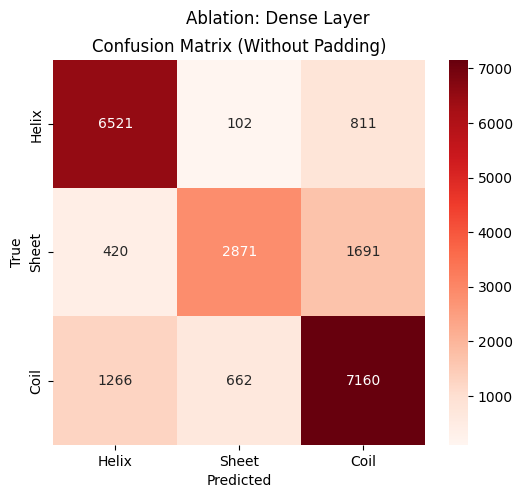

In [ ]:
cm_metrics_abl_dense= plot_confusion_matrix(m3, pssm_test, dssp_test_pssm, suptitle='Ablation: Dense Layer', color= 'Reds')

#Ablation 4: Dropout

In [ ]:
# Ablation of the Dropout
m4 = keras.Sequential()
m4.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (759,20)))
m4.add(BatchNormalization())
m4.add(Bidirectional(LSTM(64, return_sequences=True)))
# m.add(Dropout(0.3))
m4.add(Dense(128, activation= 'relu'))
m4.add(Dense(4, activation='softmax'))
m4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 759, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 759, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 759, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 759, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 759, 4)              │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,236 (340.77 KB)

 Trainable params: 87,108 (340.27 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 32
epochs = 15
m4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', masked_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = m4.fit(pssm_train, dssp_train_pssm, batch_size=batch_size,
                         epochs=epochs, validation_data=(pssm_val, dssp_val_pssm),
                         callbacks=[early_stopping])

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 951ms/step - accuracy: 0.6995 - loss: 0.7533 - masked_accuracy: 0.4460 - val_accuracy: 0.9138 - val_loss: 0.1934 - val_masked_accuracy: 0.5963
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 925ms/step - accuracy: 0.9162 - loss: 0.1909 - masked_accuracy: 0.6266 - val_accuracy: 0.9318 - val_loss: 0.1587 - val_masked_accuracy: 0.6802
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 926ms/step - accuracy: 0.9311 - loss: 0.1613 - masked_accuracy: 0.6921 - val_accuracy: 0.9378 - val_loss: 0.1470 - val_masked_accuracy: 0.7071
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9367 - loss: 0.1501 - masked_accuracy: 0.7169 - val_accuracy: 0.9414 - val_loss: 0.1394 - val_masked_accuracy: 0.7228
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 946ms/step - accuracy: 0.9402 - loss: 0.1426 - masked_accuracy: 0.7325 - val_accuracy: 0.9434 - val_loss: 0.1345 - val_masked_accuracy: 0.7314
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 951ms/step - accuracy: 0.9428 - loss

In [ ]:
abl_dropout = get_metrics(m4, history, pssm_test, dssp_test_pssm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9488 - loss: 0.1227 - masked_accuracy: 0.7679


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


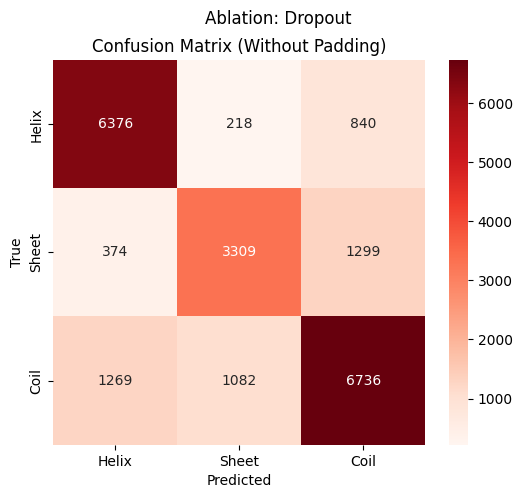

In [ ]:
cm_metrics_abl_dropout= plot_confusion_matrix(m4, pssm_test, dssp_test_pssm, suptitle='Ablation: Dropout', color= 'Reds')

#Ablation studies comparison

In [ ]:
metrics_ablations = [metrics_model2, abl_conv, abl_bidir, abl_dense, abl_dropout]
labels = ['Model', 'Ablation: Convolutional layer', 'Ablation: Bidirectional', 'Ablation: Dense Layer', 'Ablation: Dropout']
plot_model_comparison(metrics_ablations, labels, title= 'Ablations studies metrics comparison')

NameError: name 'metrics_model2' is not defined

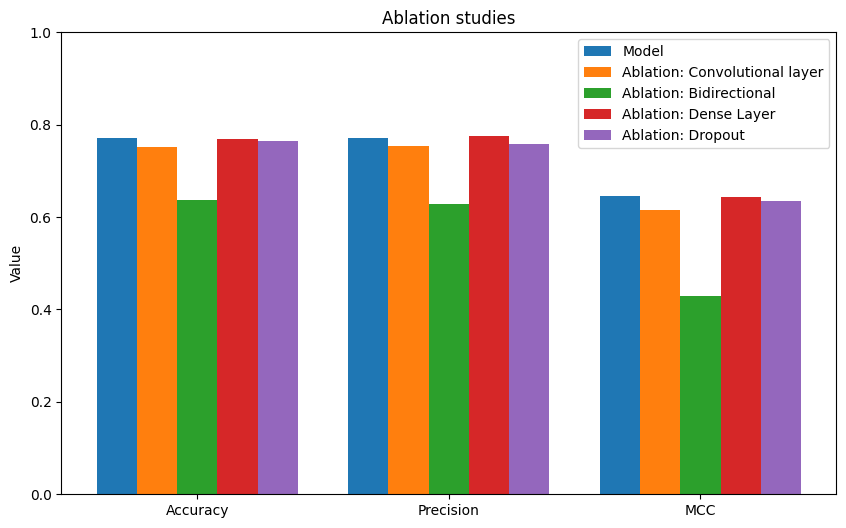

In [ ]:
cm_metrics_ablations = [cm_metrics_m2, cm_metrics_abl_con, cm_metrics_abl_bidir, cm_metrics_abl_dense, cm_metrics_abl_dropout]
labels = ['Model', 'Ablation: Convolutional layer', 'Ablation: Bidirectional', 'Ablation: Dense Layer', 'Ablation: Dropout']
plot_model_comparison(cm_metrics_ablations, labels, title= 'Ablation studies', cm= True)